Grid Search

Libraries

In [1]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

train_dir = 'processed_images'
# train_dir = 'images_train_test_val/train'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    # rotation_range=20,  # Randomly rotate images
    # width_shift_range=0.2,  # Randomly shift images horizontally
    # height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Model Creation

In [4]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [5]:
class KerasClassifierGen(KerasClassifier):
    def fit(self, x, y, **kwargs):
        return self.model.fit(x, y, **kwargs)
    
    def fit_generator(self, generator, steps_per_epoch, **kwargs):
        return self.model.fit(generator, steps_per_epoch=steps_per_epoch, **kwargs)
    
    def score(self, x, y, **kwargs):
        return self.model.evaluate(x, y, **kwargs)[1]

#create model
model = KerasClassifier(model=create_model, verbose=0)

# parameters
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'he_normal'],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Get a subset of the data
X_train, y_train = next(train_generator)
X_val, y_val = next(val_generator)


# Fit the grid search
grid_result = grid.fit(X_train, y_train)

2024-07-14 00:34:10.986128: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-14 00:34:10.986284: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-14 00:34:10.986299: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-14 00:34:10.986349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-14 00:34:10.986727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-14 00:34:11.771595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [6]:
# Retrieve best Keras Classfiier
best_params = grid_result.best_params_
best_model = create_model(optimizer=best_params['optimizer'], init_mode=best_params['model__init_mode'])

history = best_model.fit(
    train_generator,
    epochs=grid_result.best_params_['epochs'],
    validation_data=val_generator,
    batch_size=grid_result.best_params_['batch_size']
)

Epoch 1/10


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 150s 828ms/step - accuracy: 0.0483 - loss: 3.0506 - val_accuracy: 0.0657 - val_loss: 3.0189
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 124s 731ms/step - accuracy: 0.0675 - loss: 3.0259 - val_accuracy: 0.0933 - val_loss: 2.9812
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 117s 691ms/step - accuracy: 0.0830 - loss: 3.0010 - val_accuracy: 0.1019 - val_loss: 2.9444
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 587ms/step - accuracy: 0.0917 - loss: 2.9703 - val_accuracy: 0.1338 - val_loss: 2.9052
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 585ms/step - accuracy: 0.1054 - loss: 2.9435 - val_accuracy: 0.1505 - val_loss: 2.8580
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 582ms/step - accuracy: 0.1078 - loss: 2.9197 - val_accuracy: 0.1648 - val_loss: 2.8224
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 103s 605ms/step - accuracy: 0.1339 - loss: 2.8804 - val_accuracy: 0.1605 - val_loss: 2.7957
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 94s 555ms/step - accuracy: 0.1324 - loss: 2.8529 

In [8]:
# Print the best parameters and results
print(f"Best params: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

# Access the best model
best_model = grid_result.best_estimator_.model_

# Evaluate the model
train_loss, train_acc = best_model.evaluate(train_generator)
val_loss, val_acc = best_model.evaluate(val_generator)
test_loss, test_acc = best_model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')


Best params: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
Best score: 0.07792207792207792
165/165 ━━━━━━━━━━━━━━━━━━━━ 95s 565ms/step - accuracy: 0.0724 - loss: 3.8910
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 635ms/step - accuracy: 0.0682 - loss: 3.3267


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 605ms/step - accuracy: 0.0606 - loss: 3.4004
Train accuracy: 0.0728, Validation accuracy: 0.0705, Test accuracy: 0.0619


Plotting

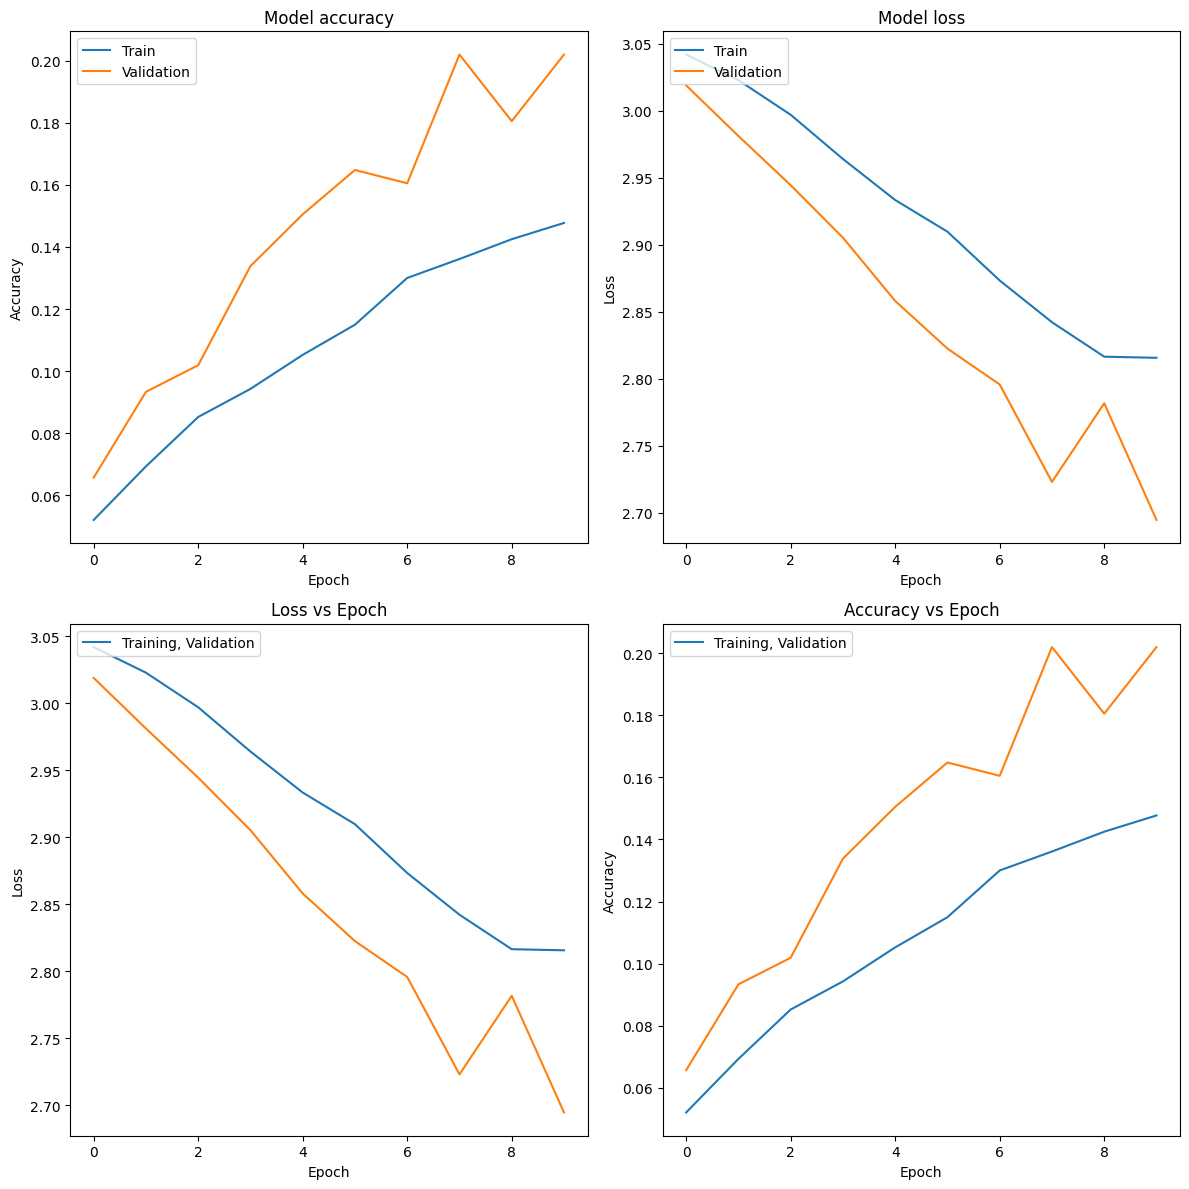

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training loss vs epoch
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training, Validation'], loc='upper left')

# Plot training accuracy vs epoch
plt.subplot(2, 2, 4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training, Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best: 0.06363636363636364 using {'batch_size': 20, 'epochs': 20, 'model__init_mode': 'he_normal', 'optimizer': 'Adam'}
0.0 (0.0) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
0.0 (0.0) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'uniform', 'optimizer': 'Adam'}
0.03333333333333333 (0.047140452079103175) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'he_normal', 'optimizer': 'SGD'}
0.0 (0.0) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'he_normal', 'optimizer': 'Adam'}
0.0 (0.0) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
0.030303030303030304 (0.04285495643554834) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'uniform', 'optimizer': 'Adam'}
0.030303030303030304 (0.04285495643554834) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'he_normal', 'optimizer': 'SGD'}
0.06060606060606061 (0.04285495643554833) with: {'batch_size': 10, 'epoch